Bienvenue au sein de ce Jupyter Notebook dédié au projet numéro 5 du parcours de Data Scientist, nommé "Segmentez des clients d'un site e-commerce".

Au sein de cette première étape, je vais vous présenter les requêtes SQL demandées par le client pour ce projet :
Liste de requêtes SQL pour le dashboard :

● En excluant les commandes annulées, quelles sont les commandes récentes de moins de 3 mois que les clients ont reçues avec au moins 3 jours de retard ?

● Qui sont les vendeurs ayant généré un chiffre d'affaires de plus de 100 000 Real sur des commandes livrées via Olist ?

● Qui sont les nouveaux vendeurs (moins de 3 mois d'ancienneté) qui sont déjà très engagés avec la plateforme (ayant déjà vendu plus de 30 produits) ?

● Question : Quels sont les 5 codes postaux, enregistrant plus de 30 reviews, avec le pire review score moyen sur les 12 derniers mois ?

Tout d'abord, nous allons importer les données nécessaires pour remplir notre mission, à l'aide du module pandas.

In [2]:
import pandas as pd
df_customer = pd.read_csv('/content/drive/MyDrive/Projet 5 : Segmentez des clients dun site e-commerce/archive (42)/olist_customers_dataset.csv')
df_geo = pd.read_csv('/content/drive/MyDrive/Projet 5 : Segmentez des clients dun site e-commerce/archive (42)/olist_geolocation_dataset.csv')
df_order_item = pd.read_csv('/content/drive/MyDrive/Projet 5 : Segmentez des clients dun site e-commerce/archive (42)/olist_order_items_dataset.csv')
df_order_payment = pd.read_csv('/content/drive/MyDrive/Projet 5 : Segmentez des clients dun site e-commerce/archive (42)/olist_order_payments_dataset.csv')
df_order_review = pd.read_csv('/content/drive/MyDrive/Projet 5 : Segmentez des clients dun site e-commerce/archive (42)/olist_order_reviews_dataset.csv')
df_orders = pd.read_csv('/content/drive/MyDrive/Projet 5 : Segmentez des clients dun site e-commerce/archive (42)/olist_orders_dataset.csv')
df_products = pd.read_csv('/content/drive/MyDrive/Projet 5 : Segmentez des clients dun site e-commerce/archive (42)/olist_products_dataset.csv')
df_sellers = pd.read_csv('/content/drive/MyDrive/Projet 5 : Segmentez des clients dun site e-commerce/archive (42)/olist_sellers_dataset.csv')
df_product_category = pd.read_csv('/content/drive/MyDrive/Projet 5 : Segmentez des clients dun site e-commerce/archive (42)/product_category_name_translation.csv')


La base de données relationnelle regroupant les datasets Olist est représentée par le schéma ci-dessous. Il met en évidence les relations entre les différentes tables.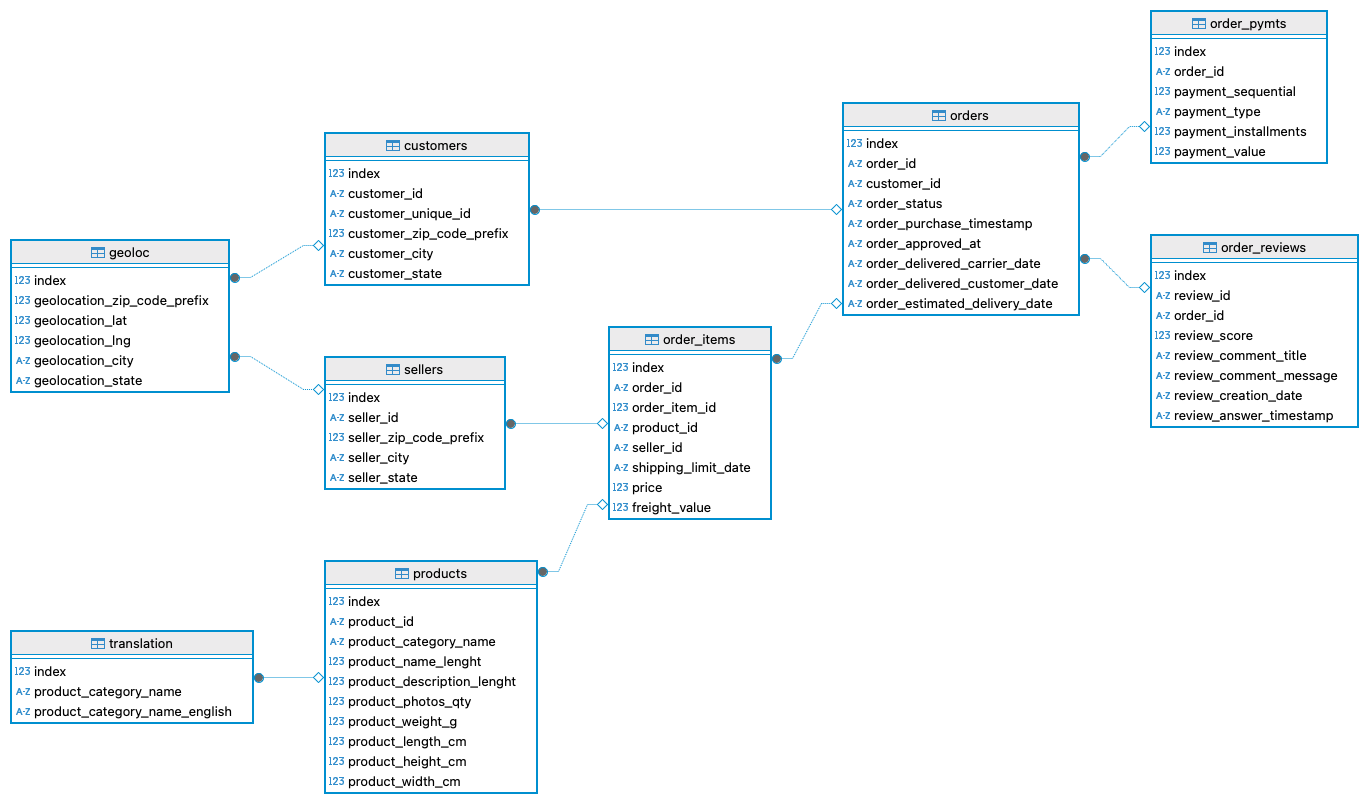

Ensuite, il faut installer le module permettant de réaliser du code SQL au sein de ce Jupyter Notebook, nommé pandasql.

In [3]:
!pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=720bb6dca1405f4c475d0c81925ef0300a76a2aacb6b99e0c55d983f8a9a9a33
  Stored in directory: /root/.cache/pip/wheels/68/5d/a5/edc271b998f909801d7956959f699b976cc9896075dc47c153
Successfully built pandasql


Maintenant, nous pouvons traiter les demandes faites par notre client Olist.

///////

**Requête numéro 1 :**

///////

En excluant les commandes annulées, quelles sont les commandes récentes de moins de 3 mois que les clients ont reçues avec au moins 3 jours de retard ?

In [4]:
from pandasql import sqldf

query_1 = """WITH latest_order as(
select max(order_purchase_timestamp)
from df_orders
)
SELECT *, JULIANDAY(order_delivered_customer_date) -
JULIANDAY(order_estimated_delivery_date) as delta
FROM df_orders
WHERE order_purchase_timestamp >= DATE((SELECT * from latest_order),
'-3 months')
AND delta >= 3
AND order_status <> 'canceled'"""
result_1= sqldf(query_1,locals())
print(result_1)

                             order_id                       customer_id  \
0    cfa4fa27b417971e86d8127cb688712f  7093250e1741ebbed41f0cc552025fd6   
1    234c056c50619f48da64f731c48242b4  44e460a655f7154ccd9faa4dbbbaf68a   
2    8ad3f1d0f96992e43566c4c82c9f6c58  948b29e24216a05fea13a18d8db45ea5   
3    7f579e203c931f3e8410103359c6d523  d665be250d1c687c58fdea61a9b55a58   
4    cb6e441ff2ef574ce08d3709426f88ec  4fb843d304c57182d4aa27bb39ca592b   
..                                ...                               ...   
317  874a7690bc049bd4ce210d195bdfff7b  f6b2c83ea477af36f44a1e2df7320036   
318  587e32dd528769d669d539531d32aeb5  0af8a25fb0b6f833724bb5818275807b   
319  3adb141ba4bd69dd7fe8d3fb733c6b74  c0539d5c87fc7c97a8418adffe4b45f0   
320  4cf09d9e5ebbe0f91ddd7bf9aae891cd  07b6b4fe5fefb948fc76b6d2bdba77d8   
321  b3112ca67f3afd4e20cf2ee91fc4f804  6f83c71b6c044fb156d697d4130fe9b5   

    order_status order_purchase_timestamp    order_approved_at  \
0      delivered      2018-08-16 

///////

**Requête numéro 2 :**

///////

Qui sont les vendeurs ayant généré un chiffre d'affaires de plus de 100 000 Real sur des commandes livrées via Olist ?

In [5]:
query_sellers_revenue = """WITH orders_joined as (
SELECT i.seller_id,
i.order_id,
i.price,
o.order_purchase_timestamp

from df_order_item as i
INNER JOIN df_orders as o
on o.order_id = i.order_id
where o.order_status = 'delivered'
order by seller_id, order_purchase_timestamp
),
aggregation as (
SELECT seller_id, sum(price) as total_amount_sold,
count(order_id) as total_items_sold

FROM orders_joined
group by seller_id
)
select * from aggregation
where total_amount_sold > 100000
order by total_amount_sold desc"""

result_sellers_revenue = sqldf(query_sellers_revenue, locals())
print(result_sellers_revenue)

                           seller_id  total_amount_sold  total_items_sold
0   4869f7a5dfa277a7dca6462dcf3b52b2          226987.93              1148
1   53243585a1d6dc2643021fd1853d8905          217940.44               400
2   4a3ca9315b744ce9f8e9374361493884          196882.12              1949
3   fa1c13f2614d7b5c4749cbc52fecda94          190917.14               579
4   7c67e1448b00f6e969d365cea6b010ab          186570.05              1355
5   7e93a43ef30c4f03f38b393420bc753a          165981.49               322
6   da8622b14eb17ae2831f4ac5b9dab84a          159816.87              1548
7   7a67c85e85bb2ce8582c35f2203ad736          139658.69              1155
8   1025f0e2d44d7041d6cf58b6550e0bfa          138208.56              1420
9   955fee9216a65b617aa5c0531780ce60          131836.71              1472
10  46dc3b2cc0980fb8ec44634e21d2718e          122811.38               523
11  6560211a19b47992c3666cc44a7e94c0          120702.83              1996
12  620c87c171fb2a6dd6e8bb4dec959fc6  

///////

**Requête numéro 3 :**

///////

Qui sont les nouveaux vendeurs (moins de 3 mois d'ancienneté) qui sont déjà très engagés avec la plateforme (ayant déjà vendu plus de 30 produits) ?

In [6]:
query_new_engaged_sellers = """
WITH latest_order AS(
SELECT MAX(order_purchase_timestamp)
from df_orders
),
orders_joined AS (
SELECT DISTINCT i.seller_id,
i.order_id,
i.price,
o.order_purchase_timestamp

from df_order_item as i
INNER JOIN df_orders as o
on o.order_id = i.order_id
where o.order_status = 'delivered'
order by seller_id, order_purchase_timestamp
),
aggregation as (
SELECT seller_id, sum(price) as total_amount_sold,
count(order_id) as total_items_sold

FROM orders_joined
group by seller_id
HAVING MIN(order_purchase_timestamp) > DATE((SELECT * FROM latest_order),'-3 months')
)
select * from aggregation
where total_items_sold > 30

"""

result_new_engaged_sellers = sqldf(query_new_engaged_sellers, locals())
print(result_new_engaged_sellers)

                          seller_id  total_amount_sold  total_items_sold
0  240b9776d844d37535668549a396af32           13332.09                35
1  81f89e42267213cb94da7ddc301651da            3522.00                46
2  d13e50eaa47b4cbe9eb81465865d8cfc            6987.15                67


///////

**Question : Quels sont les 5 codes postaux, enregistrant plus de 30 reviews, avec le pire review score moyen sur les 12 derniers mois ?**

///////

In [7]:
query_worst_review_score = """
SELECT
    AVG(dr.review_score) as mean_review_score,
    c.customer_zip_code_prefix as code_postal,
    COUNT(dr.review_id) as review_count
FROM df_order_review dr
JOIN df_orders o ON o.order_id=dr.order_id
JOIN df_customer c ON c.customer_id=o.customer_id
WHERE o.order_purchase_timestamp >= strftime('%Y-%m-%d %H:%M:%S', (SELECT MAX(order_purchase_timestamp) FROM df_orders), '-12 months')
GROUP BY code_postal
HAVING review_count > 30
ORDER BY mean_review_score ASC
LIMIT 5
"""

worst_review_score = sqldf(query_worst_review_score, locals())
print(worst_review_score)

   mean_review_score  code_postal  review_count
0           2.808511        22753            47
1           3.135135        22770            37
2           3.233333        22793            90
3           3.277778        21321            36
4           3.351351        22780            37
